In [119]:
import gensim 
import pandas as pd
import logging
import math
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import re


## Preprocessing and feature engineering

In [131]:
songs = pd.read_csv('spotify_dataset.csv', header=None, skiprows=[0], usecols=[0,1,2,3]).dropna()
songs.columns = ['user_id', 'artistname','trackname','playlistname']

In [56]:
display(songs.shape)
display(songs['trackname'].nunique())

(12867139, 4)

2009210

In [63]:
print(songs[songs['artistname'] == 'Pink Floyd'].trackname[0:100].to_string())

896                                           Sorrow - Live
1057                                       Comfortably Numb
1058                                Comfortably Numb - Live
1098                       Echoes - 2011 Remastered Version
1099                      Eclipse - 2011 Remastered Version
1186                                         Hey You - Live
1187                                      High Hopes - Live
1414                      Shine On You Crazy Diamond - Live
1554       Welcome To The Machine - 2011 Remastered Version
1568                   Wish You Were Here - 2011 - Remaster
4193                 Brain Damage - 2011 Remastered Version
5123                 Echoes - Edit; 2001 Remastered Version
5353                     Fearless - 2011 Remastered Version
7647                        Money - 2011 Remastered Version
10929                                    Wish You Were Here
10930                  Wish You Were Here - 2011 - Remaster
11229                Brain Damage - 2011

In [64]:
#Every artist can have only one version of the song, reduces unique songs from 2009210 to 1367548

def preprocess_track(trackname):

    trackname = trackname.lower()
    
    
    # everything between [], () is often live remaster etc.
    trackname = re.sub("[\(\[].*?[\)\]]", "", trackname)
    
    #"remove different identifiers only difference of couple of thousand words
    #removed_words = ['radio edit', 'explicit', 'live', 'remaster', 'remastered', 'remix','mix', 'vevo', 'version']
    #for i in removed_words:
    #    trackname = trackname.replace(i, '')
        
    #Remove everything after '-' as they most likely are live, remastered, year etc identifiers
    trackname = trackname.split('-', 1)[0]
    #Remove empty spaces around the trackname
    trackname = trackname.strip()     
       
    return trackname

In [132]:
songs['trackname'] = songs['trackname'].copy().apply(preprocess_track)
#Alternatively only song names to lowercase
#songs['trackname'] = songs['trackname'].map(lambda x: x.lower())
songs['artistname'] = songs['artistname'].map(lambda x: x.lower())

In [140]:
#uniques after preprocessing
songs['trackname'].nunique()

1367499

In [141]:
print(songs[songs['artistname'] == 'pink floyd'].trackname[0:100].to_string())

896                                        w57DlMOrw53DlMOw
1057           w47DlMOmw5HDlMOrw5_DhsObw5fDnsKZw5nDmsOmw40=
1058           w47DlMOmw5HDlMOrw5_DhsObw5fDnsKZw5nDmsOmw40=
1098                                       w5DDiMOhw5rDisOs
1099                                   w5DDiMOlw5TDlcOsw5A=
1186                                   w5PDisOywovDnsOow6A=
1187                           w5PDjsOgw5PChcOhw5rDlcOew54=
1414      w57DjcOiw5nDisKZw5rDk8KZw6TDlMOuwovDiMOrw4zDn8...
1554      w6LDisOlw47DlMOmw5DChcOtw5rChcOtw5PDisKZw5jDhs...
1568       w6LDjsOsw5PChcOyw5rDmsKZw6LDisOrw5DChcOhw5DDl8Oe
4193                       w43Dl8Oaw5TDk8KZw4_DhsOmw4zDjMOe
5123                                       w5DDiMOhw5rDisOs
5353                               w5HDisOaw53DkcOew57DmA==
7647                                       w5jDlMOnw5DDng==
10929      w6LDjsOsw5PChcOyw5rDmsKZw6LDisOrw5DChcOhw5DDl8Oe
10930      w6LDjsOsw5PChcOyw5rDmsKZw6LDisOrw5DChcOhw5DDl8Oe
11229                      w43Dl8Oaw5TDk

In [142]:
#Make two new features
#trackartist: identifty the spesific track of the artist to differ between same named songs from different artist (meta2prodvec)
songs["trackartist"] = songs["artistname"] + " - " +songs["trackname"]
#userplaylist to differ between playlists named the same
songs["userplaylist"] = songs["user_id"] + " - " +songs["playlistname"]


In [143]:
songs.head()

,user_id,artistname,trackname,playlistname,trackartist,userplaylist
0,9cc0cfd4d7d7885102480dd99e7a90d6,elvis costello,w53DisOdwovDmMOhw5rDisOs,HARD ROCK 2010,elvis costello - w53DisOdwovDmMOhw5rDisOs,9cc0cfd4d7d7885102480dd99e7a90d6 - HARD ROCK 2010
1,9cc0cfd4d7d7885102480dd99e7a90d6,elvis costello & the attractions,w5vDisOaw47DisKlwovDkcOow6HDisKZw4zDk8OdwovDms...,HARD ROCK 2010,elvis costello & the attractions - w5vDisOaw47...,9cc0cfd4d7d7885102480dd99e7a90d6 - HARD ROCK 2010
2,9cc0cfd4d7d7885102480dd99e7a90d6,tiffany page,wqLChcOyw5DDhsOrw57ChcOtw5rDlMKZw5fDhsOtw5A=,HARD ROCK 2010,tiffany page - wqLChcOyw5DDhsOrw57ChcOtw5rDlMK...,9cc0cfd4d7d7885102480dd99e7a90d6 - HARD ROCK 2010
3,9cc0cfd4d7d7885102480dd99e7a90d6,elvis costello & the attractions,w4zDiMOcw5TDicOew5nDmcOswovDnMOiw5fDkcKZw5PDhs...,HARD ROCK 2010,elvis costello & the attractions - w4zDiMOcw5T...,9cc0cfd4d7d7885102480dd99e7a90d6 - HARD ROCK 2010
4,9cc0cfd4d7d7885102480dd99e7a90d6,elvis costello,w4zDkcOiw57DlMOn,HARD ROCK 2010,elvis costello - w4zDkcOiw57DlMOn,9cc0cfd4d7d7885102480dd99e7a90d6 - HARD ROCK 2010


In [144]:
#Remove playlist with less than 10 tracks and combine into lists
playlists = songs.groupby(['userplaylist']).filter(lambda x: len(x) >= 10)
playlists = playlists.groupby(['userplaylist']).agg({'trackartist':lambda x: list(x)})

In [145]:
##playlists[playlists.index.str.match('0007f3dd09c91198371454c608d47f22 - Fav songs')]
display(playlists.head())
display(playlists.shape)

,trackartist
userplaylist,
00055176fea33f6e027cd3302289378b - favs,"[jannik brunke - wpzCnQ==, green day - wp3ClsK..."
0007f3dd09c91198371454c608d47f22 - Fav songs,[bryan adams - w5TChcOdw5rChcOiw5_ChcOfw5rDl8K...
000b0f32b5739f052b9d40fcc5c41079 - Contacta,[veronica maggio - w43DhsOswovDjMOiw5fDkcOaw53...
000b0f32b5739f052b9d40fcc5c41079 - Gospel,[the worship crew - w43Dl8Oiw5LDjcOtw5DDl8KZw4...
000b0f32b5739f052b9d40fcc5c41079 - Starred,[java gospel - w4zChcObw5fDisOsw57DisOdwovDiMO...


(188437, 1)

In [146]:
def to_document(playlists):
    documents = []
    for index, row in playlists.iterrows():
        preprocessed_songs = row['trackartist']
        documents.append(preprocessed_songs)

    return documents    

In [147]:
documents = to_document(playlists)
doc_length = len(documents)

## Training Word2vec-music recommender

In [99]:
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [148]:
#Train with 80 % of the data (with cross validation) and test the final model with 20% of the data
index = np.random.choice(range(doc_length), doc_length, replace=False)
train = np.array(documents)[index[:int(doc_length * 0.8)]].tolist()
test = np.array(documents)[index[int(doc_length * 0.8):]].tolist()

In [ ]:
#Help:
#https://github.com/manasRK/word2vec-recommender/blob/master/semsim_train.py
#https://arxiv.org/abs/1804.04212
#http://mccormickml.com/2017/01/11/word2vec-tutorial-part-2-negative-sampling/
#https://stackoverflow.com/questions/38287772/cbow-v-s-skip-gram-why-invert-context-and-target-words

In [149]:
#initial parameteres from https://arxiv.org/abs/1804.04212
window_size=7
it=90#increasing this leads to returning words with wrong similarity
sample=0.001 
power_alpha=-0.5

size_embedding=50
neg_sample=5
workers=10
min_count=10

model = gensim.models.Word2Vec(train, size=size_embedding, window=window_size,
                 min_count=min_count, workers=workers, sg=1, iter=it,
                 sample=sample, negative=neg_sample, alpha=power_alpha)

model.train(train,total_examples=len(train), epochs=model.iter)

2019-03-08 20:47:35,705 : WARNING : consider setting layer size to a multiple of 4 for greater performance
2019-03-08 20:47:35,706 : INFO : collecting all words and their counts
2019-03-08 20:47:35,706 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2019-03-08 20:47:36,024 : INFO : PROGRESS: at sentence #10000, processed 653318 words, keeping 330454 word types
2019-03-08 20:47:36,393 : INFO : PROGRESS: at sentence #20000, processed 1307913 words, keeping 555310 word types
2019-03-08 20:47:36,803 : INFO : PROGRESS: at sentence #30000, processed 1952431 words, keeping 728118 word types
2019-03-08 20:47:37,185 : INFO : PROGRESS: at sentence #40000, processed 2627335 words, keeping 877803 word types
2019-03-08 20:47:37,606 : INFO : PROGRESS: at sentence #50000, processed 3317928 words, keeping 1027752 word types
2019-03-08 20:47:38,032 : INFO : PROGRESS: at sentence #60000, processed 4060883 words, keeping 1187245 word types
2019-03-08 20:47:38,431 : INFO : PROGR

2019-03-08 20:48:16,614 : INFO : EPOCH 3 - PROGRESS: at 7.25% examples, 442576 words/s, in_qsize 19, out_qsize 0
2019-03-08 20:48:17,620 : INFO : EPOCH 3 - PROGRESS: at 14.82% examples, 450916 words/s, in_qsize 19, out_qsize 0
2019-03-08 20:48:18,626 : INFO : EPOCH 3 - PROGRESS: at 22.17% examples, 455523 words/s, in_qsize 19, out_qsize 0
2019-03-08 20:48:19,631 : INFO : EPOCH 3 - PROGRESS: at 28.74% examples, 454136 words/s, in_qsize 20, out_qsize 0
2019-03-08 20:48:20,637 : INFO : EPOCH 3 - PROGRESS: at 35.84% examples, 452556 words/s, in_qsize 19, out_qsize 0
2019-03-08 20:48:21,656 : INFO : EPOCH 3 - PROGRESS: at 42.50% examples, 451857 words/s, in_qsize 19, out_qsize 0
2019-03-08 20:48:22,681 : INFO : EPOCH 3 - PROGRESS: at 49.90% examples, 451996 words/s, in_qsize 19, out_qsize 1
2019-03-08 20:48:23,681 : INFO : EPOCH 3 - PROGRESS: at 56.95% examples, 452916 words/s, in_qsize 19, out_qsize 0
2019-03-08 20:48:24,685 : INFO : EPOCH 3 - PROGRESS: at 64.05% examples, 453913 words/s, 

2019-03-08 20:49:03,414 : INFO : EPOCH 6 - PROGRESS: at 35.72% examples, 450112 words/s, in_qsize 18, out_qsize 1
2019-03-08 20:49:04,425 : INFO : EPOCH 6 - PROGRESS: at 42.41% examples, 450228 words/s, in_qsize 19, out_qsize 0
2019-03-08 20:49:05,433 : INFO : EPOCH 6 - PROGRESS: at 49.81% examples, 451859 words/s, in_qsize 20, out_qsize 0
2019-03-08 20:49:06,437 : INFO : EPOCH 6 - PROGRESS: at 56.75% examples, 451537 words/s, in_qsize 19, out_qsize 0
2019-03-08 20:49:07,446 : INFO : EPOCH 6 - PROGRESS: at 63.95% examples, 453163 words/s, in_qsize 19, out_qsize 0
2019-03-08 20:49:08,464 : INFO : EPOCH 6 - PROGRESS: at 71.03% examples, 453287 words/s, in_qsize 19, out_qsize 0
2019-03-08 20:49:09,471 : INFO : EPOCH 6 - PROGRESS: at 78.52% examples, 454653 words/s, in_qsize 18, out_qsize 1
2019-03-08 20:49:10,478 : INFO : EPOCH 6 - PROGRESS: at 86.11% examples, 455275 words/s, in_qsize 18, out_qsize 1
2019-03-08 20:49:11,478 : INFO : EPOCH 6 - PROGRESS: at 92.92% examples, 455131 words/s,

2019-03-08 20:49:49,893 : INFO : EPOCH 9 - PROGRESS: at 64.17% examples, 455643 words/s, in_qsize 18, out_qsize 1
2019-03-08 20:49:50,910 : INFO : EPOCH 9 - PROGRESS: at 71.52% examples, 456955 words/s, in_qsize 20, out_qsize 0
2019-03-08 20:49:51,913 : INFO : EPOCH 9 - PROGRESS: at 79.07% examples, 457504 words/s, in_qsize 19, out_qsize 0
2019-03-08 20:49:52,933 : INFO : EPOCH 9 - PROGRESS: at 86.36% examples, 456784 words/s, in_qsize 18, out_qsize 1
2019-03-08 20:49:53,943 : INFO : EPOCH 9 - PROGRESS: at 93.24% examples, 456271 words/s, in_qsize 17, out_qsize 2
2019-03-08 20:49:54,781 : INFO : worker thread finished; awaiting finish of 9 more threads
2019-03-08 20:49:54,821 : INFO : worker thread finished; awaiting finish of 8 more threads
2019-03-08 20:49:54,826 : INFO : worker thread finished; awaiting finish of 7 more threads
2019-03-08 20:49:54,834 : INFO : worker thread finished; awaiting finish of 6 more threads
2019-03-08 20:49:54,836 : INFO : worker thread finished; awaiting 

2019-03-08 20:50:36,192 : INFO : EPOCH 12 - PROGRESS: at 93.81% examples, 460928 words/s, in_qsize 19, out_qsize 0
2019-03-08 20:50:36,978 : INFO : worker thread finished; awaiting finish of 9 more threads
2019-03-08 20:50:37,009 : INFO : worker thread finished; awaiting finish of 8 more threads
2019-03-08 20:50:37,010 : INFO : worker thread finished; awaiting finish of 7 more threads
2019-03-08 20:50:37,035 : INFO : worker thread finished; awaiting finish of 6 more threads
2019-03-08 20:50:37,043 : INFO : worker thread finished; awaiting finish of 5 more threads
2019-03-08 20:50:37,048 : INFO : worker thread finished; awaiting finish of 4 more threads
2019-03-08 20:50:37,056 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-03-08 20:50:37,061 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-08 20:50:37,078 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-03-08 20:50:37,086 : INFO : worker thread finished; awaiting 

2019-03-08 20:51:19,221 : INFO : worker thread finished; awaiting finish of 4 more threads
2019-03-08 20:51:19,235 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-03-08 20:51:19,247 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-08 20:51:19,248 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-03-08 20:51:19,260 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-03-08 20:51:19,260 : INFO : EPOCH - 15 : training on 10168083 raw words (6450969 effective words) took 14.1s, 457675 effective words/s
2019-03-08 20:51:20,283 : INFO : EPOCH 16 - PROGRESS: at 7.25% examples, 448635 words/s, in_qsize 19, out_qsize 0
2019-03-08 20:51:21,290 : INFO : EPOCH 16 - PROGRESS: at 14.56% examples, 450846 words/s, in_qsize 18, out_qsize 1
2019-03-08 20:51:22,301 : INFO : EPOCH 16 - PROGRESS: at 22.14% examples, 456910 words/s, in_qsize 18, out_qsize 1
2019-03-08 20:51:23,316 : INFO : EPOCH 16 - PROGRESS: at 28.9

2019-03-08 20:52:02,195 : INFO : EPOCH 19 - PROGRESS: at 7.25% examples, 453293 words/s, in_qsize 19, out_qsize 0
2019-03-08 20:52:03,202 : INFO : EPOCH 19 - PROGRESS: at 14.43% examples, 446638 words/s, in_qsize 18, out_qsize 1
2019-03-08 20:52:04,224 : INFO : EPOCH 19 - PROGRESS: at 22.17% examples, 456593 words/s, in_qsize 19, out_qsize 0
2019-03-08 20:52:05,252 : INFO : EPOCH 19 - PROGRESS: at 29.05% examples, 456747 words/s, in_qsize 19, out_qsize 0
2019-03-08 20:52:06,296 : INFO : EPOCH 19 - PROGRESS: at 36.60% examples, 457221 words/s, in_qsize 20, out_qsize 0
2019-03-08 20:52:07,296 : INFO : EPOCH 19 - PROGRESS: at 43.62% examples, 460231 words/s, in_qsize 19, out_qsize 0
2019-03-08 20:52:08,325 : INFO : EPOCH 19 - PROGRESS: at 51.08% examples, 460001 words/s, in_qsize 19, out_qsize 0
2019-03-08 20:52:09,336 : INFO : EPOCH 19 - PROGRESS: at 58.11% examples, 459646 words/s, in_qsize 20, out_qsize 0
2019-03-08 20:52:10,354 : INFO : EPOCH 19 - PROGRESS: at 64.99% examples, 458634 

2019-03-08 20:52:48,588 : INFO : EPOCH 22 - PROGRESS: at 36.01% examples, 456650 words/s, in_qsize 18, out_qsize 1
2019-03-08 20:52:49,611 : INFO : EPOCH 22 - PROGRESS: at 42.96% examples, 456533 words/s, in_qsize 19, out_qsize 0
2019-03-08 20:52:50,616 : INFO : EPOCH 22 - PROGRESS: at 50.30% examples, 457020 words/s, in_qsize 19, out_qsize 1
2019-03-08 20:52:51,638 : INFO : EPOCH 22 - PROGRESS: at 57.53% examples, 458258 words/s, in_qsize 19, out_qsize 0
2019-03-08 20:52:52,641 : INFO : EPOCH 22 - PROGRESS: at 64.58% examples, 458879 words/s, in_qsize 19, out_qsize 0
2019-03-08 20:52:53,651 : INFO : EPOCH 22 - PROGRESS: at 71.73% examples, 458870 words/s, in_qsize 19, out_qsize 0
2019-03-08 20:52:54,655 : INFO : EPOCH 22 - PROGRESS: at 79.32% examples, 458880 words/s, in_qsize 18, out_qsize 1
2019-03-08 20:52:55,675 : INFO : EPOCH 22 - PROGRESS: at 86.86% examples, 459433 words/s, in_qsize 20, out_qsize 0
2019-03-08 20:52:56,699 : INFO : EPOCH 22 - PROGRESS: at 93.81% examples, 459692

2019-03-08 20:53:35,798 : INFO : EPOCH 25 - PROGRESS: at 67.53% examples, 432677 words/s, in_qsize 19, out_qsize 0
2019-03-08 20:53:36,809 : INFO : EPOCH 25 - PROGRESS: at 75.04% examples, 434814 words/s, in_qsize 19, out_qsize 0
2019-03-08 20:53:37,832 : INFO : EPOCH 25 - PROGRESS: at 82.14% examples, 434630 words/s, in_qsize 19, out_qsize 0
2019-03-08 20:53:38,872 : INFO : EPOCH 25 - PROGRESS: at 89.18% examples, 433718 words/s, in_qsize 19, out_qsize 0
2019-03-08 20:53:39,885 : INFO : EPOCH 25 - PROGRESS: at 95.57% examples, 434061 words/s, in_qsize 20, out_qsize 0
2019-03-08 20:53:40,374 : INFO : worker thread finished; awaiting finish of 9 more threads
2019-03-08 20:53:40,403 : INFO : worker thread finished; awaiting finish of 8 more threads
2019-03-08 20:53:40,408 : INFO : worker thread finished; awaiting finish of 7 more threads
2019-03-08 20:53:40,429 : INFO : worker thread finished; awaiting finish of 6 more threads
2019-03-08 20:53:40,433 : INFO : worker thread finished; awai

2019-03-08 20:54:22,046 : INFO : EPOCH 28 - PROGRESS: at 93.89% examples, 458196 words/s, in_qsize 19, out_qsize 0
2019-03-08 20:54:22,758 : INFO : worker thread finished; awaiting finish of 9 more threads
2019-03-08 20:54:22,814 : INFO : worker thread finished; awaiting finish of 8 more threads
2019-03-08 20:54:22,818 : INFO : worker thread finished; awaiting finish of 7 more threads
2019-03-08 20:54:22,823 : INFO : worker thread finished; awaiting finish of 6 more threads
2019-03-08 20:54:22,843 : INFO : worker thread finished; awaiting finish of 5 more threads
2019-03-08 20:54:22,855 : INFO : worker thread finished; awaiting finish of 4 more threads
2019-03-08 20:54:22,870 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-03-08 20:54:22,873 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-08 20:54:22,881 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-03-08 20:54:22,887 : INFO : worker thread finished; awaiting 

2019-03-08 20:55:05,028 : INFO : worker thread finished; awaiting finish of 4 more threads
2019-03-08 20:55:05,042 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-03-08 20:55:05,056 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-08 20:55:05,058 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-03-08 20:55:05,058 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-03-08 20:55:05,059 : INFO : EPOCH - 31 : training on 10168083 raw words (6450969 effective words) took 14.1s, 457693 effective words/s
2019-03-08 20:55:06,075 : INFO : EPOCH 32 - PROGRESS: at 7.25% examples, 451298 words/s, in_qsize 19, out_qsize 0
2019-03-08 20:55:07,076 : INFO : EPOCH 32 - PROGRESS: at 14.33% examples, 443490 words/s, in_qsize 20, out_qsize 1
2019-03-08 20:55:08,094 : INFO : EPOCH 32 - PROGRESS: at 22.05% examples, 455389 words/s, in_qsize 18, out_qsize 1
2019-03-08 20:55:09,121 : INFO : EPOCH 32 - PROGRESS: at 28.9

2019-03-08 20:55:47,471 : INFO : EPOCH - 34 : training on 10168083 raw words (6450969 effective words) took 14.1s, 456793 effective words/s
2019-03-08 20:55:48,489 : INFO : EPOCH 35 - PROGRESS: at 7.14% examples, 444207 words/s, in_qsize 19, out_qsize 0
2019-03-08 20:55:49,490 : INFO : EPOCH 35 - PROGRESS: at 14.43% examples, 446707 words/s, in_qsize 19, out_qsize 0
2019-03-08 20:55:50,502 : INFO : EPOCH 35 - PROGRESS: at 22.14% examples, 458397 words/s, in_qsize 18, out_qsize 1
2019-03-08 20:55:51,514 : INFO : EPOCH 35 - PROGRESS: at 28.95% examples, 458130 words/s, in_qsize 19, out_qsize 0
2019-03-08 20:55:52,535 : INFO : EPOCH 35 - PROGRESS: at 36.44% examples, 460196 words/s, in_qsize 19, out_qsize 0
2019-03-08 20:55:53,547 : INFO : EPOCH 35 - PROGRESS: at 43.09% examples, 458002 words/s, in_qsize 18, out_qsize 1
2019-03-08 20:55:54,549 : INFO : EPOCH 35 - PROGRESS: at 50.08% examples, 454885 words/s, in_qsize 20, out_qsize 0
2019-03-08 20:55:55,555 : INFO : EPOCH 35 - PROGRESS: at

2019-03-08 20:56:32,564 : INFO : EPOCH 38 - PROGRESS: at 13.34% examples, 412806 words/s, in_qsize 18, out_qsize 1
2019-03-08 20:56:33,601 : INFO : EPOCH 38 - PROGRESS: at 20.75% examples, 420814 words/s, in_qsize 20, out_qsize 0
2019-03-08 20:56:34,605 : INFO : EPOCH 38 - PROGRESS: at 27.54% examples, 430536 words/s, in_qsize 19, out_qsize 0
2019-03-08 20:56:35,614 : INFO : EPOCH 38 - PROGRESS: at 34.60% examples, 436272 words/s, in_qsize 19, out_qsize 0
2019-03-08 20:56:36,615 : INFO : EPOCH 38 - PROGRESS: at 41.42% examples, 438812 words/s, in_qsize 19, out_qsize 0
2019-03-08 20:56:37,622 : INFO : EPOCH 38 - PROGRESS: at 48.88% examples, 442182 words/s, in_qsize 20, out_qsize 0
2019-03-08 20:56:38,627 : INFO : EPOCH 38 - PROGRESS: at 56.01% examples, 444546 words/s, in_qsize 20, out_qsize 2
2019-03-08 20:56:39,649 : INFO : EPOCH 38 - PROGRESS: at 62.70% examples, 443588 words/s, in_qsize 19, out_qsize 0
2019-03-08 20:56:40,650 : INFO : EPOCH 38 - PROGRESS: at 69.49% examples, 444794

2019-03-08 20:57:18,827 : INFO : EPOCH 41 - PROGRESS: at 35.93% examples, 454521 words/s, in_qsize 17, out_qsize 2
2019-03-08 20:57:19,829 : INFO : EPOCH 41 - PROGRESS: at 42.72% examples, 455620 words/s, in_qsize 20, out_qsize 1
2019-03-08 20:57:20,849 : INFO : EPOCH 41 - PROGRESS: at 50.30% examples, 457181 words/s, in_qsize 19, out_qsize 0
2019-03-08 20:57:21,860 : INFO : EPOCH 41 - PROGRESS: at 57.43% examples, 458062 words/s, in_qsize 18, out_qsize 1
2019-03-08 20:57:22,875 : INFO : EPOCH 41 - PROGRESS: at 64.46% examples, 458199 words/s, in_qsize 18, out_qsize 1
2019-03-08 20:57:23,884 : INFO : EPOCH 41 - PROGRESS: at 71.68% examples, 458564 words/s, in_qsize 19, out_qsize 0
2019-03-08 20:57:24,901 : INFO : EPOCH 41 - PROGRESS: at 79.21% examples, 457856 words/s, in_qsize 19, out_qsize 0
2019-03-08 20:57:25,907 : INFO : EPOCH 41 - PROGRESS: at 86.48% examples, 457606 words/s, in_qsize 18, out_qsize 1
2019-03-08 20:57:26,908 : INFO : EPOCH 41 - PROGRESS: at 93.65% examples, 458990

2019-03-08 20:58:05,929 : INFO : EPOCH 44 - PROGRESS: at 71.67% examples, 457499 words/s, in_qsize 19, out_qsize 0
2019-03-08 20:58:06,958 : INFO : EPOCH 44 - PROGRESS: at 79.41% examples, 457812 words/s, in_qsize 20, out_qsize 1
2019-03-08 20:58:07,972 : INFO : EPOCH 44 - PROGRESS: at 86.98% examples, 458699 words/s, in_qsize 19, out_qsize 0
2019-03-08 20:58:08,976 : INFO : EPOCH 44 - PROGRESS: at 93.81% examples, 459168 words/s, in_qsize 19, out_qsize 0
2019-03-08 20:58:09,719 : INFO : worker thread finished; awaiting finish of 9 more threads
2019-03-08 20:58:09,763 : INFO : worker thread finished; awaiting finish of 8 more threads
2019-03-08 20:58:09,767 : INFO : worker thread finished; awaiting finish of 7 more threads
2019-03-08 20:58:09,787 : INFO : worker thread finished; awaiting finish of 6 more threads
2019-03-08 20:58:09,794 : INFO : worker thread finished; awaiting finish of 5 more threads
2019-03-08 20:58:09,812 : INFO : worker thread finished; awaiting finish of 4 more th

2019-03-08 20:58:51,720 : INFO : EPOCH 47 - PROGRESS: at 92.63% examples, 453296 words/s, in_qsize 20, out_qsize 0
2019-03-08 20:58:52,647 : INFO : worker thread finished; awaiting finish of 9 more threads
2019-03-08 20:58:52,685 : INFO : worker thread finished; awaiting finish of 8 more threads
2019-03-08 20:58:52,692 : INFO : worker thread finished; awaiting finish of 7 more threads
2019-03-08 20:58:52,694 : INFO : worker thread finished; awaiting finish of 6 more threads
2019-03-08 20:58:52,700 : INFO : worker thread finished; awaiting finish of 5 more threads
2019-03-08 20:58:52,726 : INFO : EPOCH 47 - PROGRESS: at 99.55% examples, 454119 words/s, in_qsize 4, out_qsize 1
2019-03-08 20:58:52,727 : INFO : worker thread finished; awaiting finish of 4 more threads
2019-03-08 20:58:52,740 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-03-08 20:58:52,743 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-08 20:58:52,750 : INFO : worker thr

2019-03-08 20:59:35,364 : INFO : worker thread finished; awaiting finish of 6 more threads
2019-03-08 20:59:35,372 : INFO : worker thread finished; awaiting finish of 5 more threads
2019-03-08 20:59:35,399 : INFO : worker thread finished; awaiting finish of 4 more threads
2019-03-08 20:59:35,413 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-03-08 20:59:35,419 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-08 20:59:35,426 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-03-08 20:59:35,430 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-03-08 20:59:35,430 : INFO : EPOCH - 50 : training on 10168083 raw words (6450969 effective words) took 14.1s, 458096 effective words/s
2019-03-08 20:59:36,469 : INFO : EPOCH 51 - PROGRESS: at 7.29% examples, 446085 words/s, in_qsize 19, out_qsize 0
2019-03-08 20:59:37,480 : INFO : EPOCH 51 - PROGRESS: at 14.93% examples, 455477 words/s, in_qsize 19, out_qs

2019-03-08 21:00:17,507 : INFO : EPOCH - 53 : training on 10168083 raw words (6450969 effective words) took 14.1s, 458133 effective words/s
2019-03-08 21:00:18,532 : INFO : EPOCH 54 - PROGRESS: at 7.03% examples, 436692 words/s, in_qsize 17, out_qsize 2
2019-03-08 21:00:19,540 : INFO : EPOCH 54 - PROGRESS: at 14.72% examples, 450348 words/s, in_qsize 19, out_qsize 0
2019-03-08 21:00:20,553 : INFO : EPOCH 54 - PROGRESS: at 22.17% examples, 455924 words/s, in_qsize 18, out_qsize 1
2019-03-08 21:00:21,586 : INFO : EPOCH 54 - PROGRESS: at 29.07% examples, 455672 words/s, in_qsize 18, out_qsize 1
2019-03-08 21:00:22,641 : INFO : EPOCH 54 - PROGRESS: at 36.60% examples, 455262 words/s, in_qsize 20, out_qsize 0
2019-03-08 21:00:23,651 : INFO : EPOCH 54 - PROGRESS: at 43.84% examples, 460827 words/s, in_qsize 19, out_qsize 0
2019-03-08 21:00:24,663 : INFO : EPOCH 54 - PROGRESS: at 51.16% examples, 459311 words/s, in_qsize 19, out_qsize 0
2019-03-08 21:00:25,668 : INFO : EPOCH 54 - PROGRESS: at

2019-03-08 21:01:03,338 : INFO : EPOCH 57 - PROGRESS: at 21.30% examples, 440666 words/s, in_qsize 20, out_qsize 0
2019-03-08 21:01:04,350 : INFO : EPOCH 57 - PROGRESS: at 28.31% examples, 448452 words/s, in_qsize 20, out_qsize 0
2019-03-08 21:01:05,366 : INFO : EPOCH 57 - PROGRESS: at 35.25% examples, 446778 words/s, in_qsize 20, out_qsize 1
2019-03-08 21:01:06,378 : INFO : EPOCH 57 - PROGRESS: at 42.13% examples, 446518 words/s, in_qsize 18, out_qsize 1
2019-03-08 21:01:07,404 : INFO : EPOCH 57 - PROGRESS: at 49.04% examples, 443511 words/s, in_qsize 19, out_qsize 0
2019-03-08 21:01:08,417 : INFO : EPOCH 57 - PROGRESS: at 55.88% examples, 443033 words/s, in_qsize 20, out_qsize 2
2019-03-08 21:01:09,423 : INFO : EPOCH 57 - PROGRESS: at 62.09% examples, 439106 words/s, in_qsize 18, out_qsize 1
2019-03-08 21:01:10,466 : INFO : EPOCH 57 - PROGRESS: at 68.99% examples, 439523 words/s, in_qsize 18, out_qsize 1
2019-03-08 21:01:11,485 : INFO : EPOCH 57 - PROGRESS: at 76.63% examples, 441401

2019-03-08 21:01:50,046 : INFO : EPOCH 60 - PROGRESS: at 51.08% examples, 461636 words/s, in_qsize 19, out_qsize 0
2019-03-08 21:01:51,056 : INFO : EPOCH 60 - PROGRESS: at 58.12% examples, 461193 words/s, in_qsize 18, out_qsize 1
2019-03-08 21:01:52,056 : INFO : EPOCH 60 - PROGRESS: at 65.09% examples, 461413 words/s, in_qsize 18, out_qsize 1
2019-03-08 21:01:53,069 : INFO : EPOCH 60 - PROGRESS: at 72.30% examples, 461040 words/s, in_qsize 19, out_qsize 0
2019-03-08 21:01:54,071 : INFO : EPOCH 60 - PROGRESS: at 80.19% examples, 461817 words/s, in_qsize 19, out_qsize 0
2019-03-08 21:01:55,089 : INFO : EPOCH 60 - PROGRESS: at 87.51% examples, 461736 words/s, in_qsize 19, out_qsize 0
2019-03-08 21:01:56,091 : INFO : EPOCH 60 - PROGRESS: at 94.36% examples, 462149 words/s, in_qsize 19, out_qsize 0
2019-03-08 21:01:56,763 : INFO : worker thread finished; awaiting finish of 9 more threads
2019-03-08 21:01:56,791 : INFO : worker thread finished; awaiting finish of 8 more threads
2019-03-08 21

2019-03-08 21:02:36,212 : INFO : EPOCH 63 - PROGRESS: at 78.16% examples, 451461 words/s, in_qsize 19, out_qsize 1
2019-03-08 21:02:37,235 : INFO : EPOCH 63 - PROGRESS: at 85.45% examples, 450661 words/s, in_qsize 18, out_qsize 1
2019-03-08 21:02:38,238 : INFO : EPOCH 63 - PROGRESS: at 92.21% examples, 450235 words/s, in_qsize 18, out_qsize 1
2019-03-08 21:02:39,239 : INFO : EPOCH 63 - PROGRESS: at 99.14% examples, 450901 words/s, in_qsize 9, out_qsize 1
2019-03-08 21:02:39,242 : INFO : worker thread finished; awaiting finish of 9 more threads
2019-03-08 21:02:39,278 : INFO : worker thread finished; awaiting finish of 8 more threads
2019-03-08 21:02:39,281 : INFO : worker thread finished; awaiting finish of 7 more threads
2019-03-08 21:02:39,297 : INFO : worker thread finished; awaiting finish of 6 more threads
2019-03-08 21:02:39,308 : INFO : worker thread finished; awaiting finish of 5 more threads
2019-03-08 21:02:39,319 : INFO : worker thread finished; awaiting finish of 4 more thr

2019-03-08 21:03:21,269 : INFO : EPOCH 66 - PROGRESS: at 93.89% examples, 458979 words/s, in_qsize 19, out_qsize 0
2019-03-08 21:03:22,017 : INFO : worker thread finished; awaiting finish of 9 more threads
2019-03-08 21:03:22,045 : INFO : worker thread finished; awaiting finish of 8 more threads
2019-03-08 21:03:22,063 : INFO : worker thread finished; awaiting finish of 7 more threads
2019-03-08 21:03:22,067 : INFO : worker thread finished; awaiting finish of 6 more threads
2019-03-08 21:03:22,079 : INFO : worker thread finished; awaiting finish of 5 more threads
2019-03-08 21:03:22,091 : INFO : worker thread finished; awaiting finish of 4 more threads
2019-03-08 21:03:22,102 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-03-08 21:03:22,109 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-08 21:03:22,116 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-03-08 21:03:22,129 : INFO : worker thread finished; awaiting 

2019-03-08 21:04:04,988 : INFO : worker thread finished; awaiting finish of 7 more threads
2019-03-08 21:04:04,990 : INFO : worker thread finished; awaiting finish of 6 more threads
2019-03-08 21:04:04,995 : INFO : worker thread finished; awaiting finish of 5 more threads
2019-03-08 21:04:05,022 : INFO : worker thread finished; awaiting finish of 4 more threads
2019-03-08 21:04:05,026 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-03-08 21:04:05,038 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-08 21:04:05,045 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-03-08 21:04:05,047 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-03-08 21:04:05,048 : INFO : EPOCH - 69 : training on 10168083 raw words (6450969 effective words) took 14.3s, 452306 effective words/s
2019-03-08 21:04:06,058 : INFO : EPOCH 70 - PROGRESS: at 7.25% examples, 454016 words/s, in_qsize 19, out_qsize 0
2019-03-08 21:04:0

2019-03-08 21:04:48,332 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-03-08 21:04:48,344 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-08 21:04:48,345 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-03-08 21:04:48,346 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-03-08 21:04:48,347 : INFO : EPOCH - 72 : training on 10168083 raw words (6450969 effective words) took 14.5s, 445737 effective words/s
2019-03-08 21:04:49,367 : INFO : EPOCH 73 - PROGRESS: at 6.94% examples, 432791 words/s, in_qsize 17, out_qsize 2
2019-03-08 21:04:50,382 : INFO : EPOCH 73 - PROGRESS: at 14.34% examples, 439715 words/s, in_qsize 20, out_qsize 1
2019-03-08 21:04:51,386 : INFO : EPOCH 73 - PROGRESS: at 21.86% examples, 448989 words/s, in_qsize 20, out_qsize 1
2019-03-08 21:04:52,392 : INFO : EPOCH 73 - PROGRESS: at 28.47% examples, 451361 words/s, in_qsize 19, out_qsize 0
2019-03-08 21:04:53,412 : INFO : EPOC

2019-03-08 21:05:30,890 : INFO : EPOCH - 75 : training on 10168083 raw words (6450969 effective words) took 14.1s, 456376 effective words/s
2019-03-08 21:05:31,900 : INFO : EPOCH 76 - PROGRESS: at 6.64% examples, 423771 words/s, in_qsize 18, out_qsize 1
2019-03-08 21:05:32,906 : INFO : EPOCH 76 - PROGRESS: at 14.33% examples, 443750 words/s, in_qsize 19, out_qsize 0
2019-03-08 21:05:33,932 : INFO : EPOCH 76 - PROGRESS: at 21.77% examples, 448183 words/s, in_qsize 18, out_qsize 2
2019-03-08 21:05:34,935 : INFO : EPOCH 76 - PROGRESS: at 28.60% examples, 453136 words/s, in_qsize 19, out_qsize 0
2019-03-08 21:05:35,952 : INFO : EPOCH 76 - PROGRESS: at 35.53% examples, 449121 words/s, in_qsize 18, out_qsize 1
2019-03-08 21:05:36,962 : INFO : EPOCH 76 - PROGRESS: at 42.27% examples, 449316 words/s, in_qsize 18, out_qsize 1
2019-03-08 21:05:37,965 : INFO : EPOCH 76 - PROGRESS: at 49.61% examples, 450064 words/s, in_qsize 18, out_qsize 1
2019-03-08 21:05:39,010 : INFO : EPOCH 76 - PROGRESS: at

2019-03-08 21:06:16,280 : INFO : EPOCH 79 - PROGRESS: at 14.33% examples, 439257 words/s, in_qsize 20, out_qsize 0
2019-03-08 21:06:17,285 : INFO : EPOCH 79 - PROGRESS: at 21.96% examples, 452183 words/s, in_qsize 18, out_qsize 1
2019-03-08 21:06:18,325 : INFO : EPOCH 79 - PROGRESS: at 28.80% examples, 452048 words/s, in_qsize 19, out_qsize 0
2019-03-08 21:06:19,337 : INFO : EPOCH 79 - PROGRESS: at 36.19% examples, 454919 words/s, in_qsize 19, out_qsize 0
2019-03-08 21:06:20,346 : INFO : EPOCH 79 - PROGRESS: at 42.92% examples, 454073 words/s, in_qsize 19, out_qsize 0
2019-03-08 21:06:21,348 : INFO : EPOCH 79 - PROGRESS: at 49.85% examples, 451399 words/s, in_qsize 19, out_qsize 0
2019-03-08 21:06:22,359 : INFO : EPOCH 79 - PROGRESS: at 56.88% examples, 451519 words/s, in_qsize 20, out_qsize 0
2019-03-08 21:06:23,390 : INFO : EPOCH 79 - PROGRESS: at 63.92% examples, 450948 words/s, in_qsize 17, out_qsize 2
2019-03-08 21:06:24,403 : INFO : EPOCH 79 - PROGRESS: at 70.42% examples, 448353

2019-03-08 21:07:01,222 : INFO : EPOCH 82 - PROGRESS: at 29.19% examples, 456424 words/s, in_qsize 20, out_qsize 2
2019-03-08 21:07:02,259 : INFO : EPOCH 82 - PROGRESS: at 36.60% examples, 456222 words/s, in_qsize 19, out_qsize 0
2019-03-08 21:07:03,277 : INFO : EPOCH 82 - PROGRESS: at 43.84% examples, 461088 words/s, in_qsize 19, out_qsize 0
2019-03-08 21:07:04,284 : INFO : EPOCH 82 - PROGRESS: at 51.05% examples, 458900 words/s, in_qsize 19, out_qsize 0
2019-03-08 21:07:05,286 : INFO : EPOCH 82 - PROGRESS: at 57.59% examples, 456167 words/s, in_qsize 19, out_qsize 0
2019-03-08 21:07:06,288 : INFO : EPOCH 82 - PROGRESS: at 64.58% examples, 456311 words/s, in_qsize 19, out_qsize 0
2019-03-08 21:07:07,314 : INFO : EPOCH 82 - PROGRESS: at 71.68% examples, 455445 words/s, in_qsize 20, out_qsize 1
2019-03-08 21:07:08,326 : INFO : EPOCH 82 - PROGRESS: at 79.32% examples, 455840 words/s, in_qsize 20, out_qsize 1
2019-03-08 21:07:09,331 : INFO : EPOCH 82 - PROGRESS: at 86.48% examples, 455183

2019-03-08 21:07:48,417 : INFO : EPOCH 85 - PROGRESS: at 56.18% examples, 445686 words/s, in_qsize 19, out_qsize 0
2019-03-08 21:07:49,431 : INFO : EPOCH 85 - PROGRESS: at 63.05% examples, 445445 words/s, in_qsize 20, out_qsize 2
2019-03-08 21:07:50,451 : INFO : EPOCH 85 - PROGRESS: at 70.26% examples, 447975 words/s, in_qsize 20, out_qsize 1
2019-03-08 21:07:51,453 : INFO : EPOCH 85 - PROGRESS: at 77.87% examples, 449449 words/s, in_qsize 19, out_qsize 0
2019-03-08 21:07:52,454 : INFO : EPOCH 85 - PROGRESS: at 85.10% examples, 450335 words/s, in_qsize 19, out_qsize 0
2019-03-08 21:07:53,457 : INFO : EPOCH 85 - PROGRESS: at 92.09% examples, 450852 words/s, in_qsize 19, out_qsize 0
2019-03-08 21:07:54,448 : INFO : worker thread finished; awaiting finish of 9 more threads
2019-03-08 21:07:54,499 : INFO : EPOCH 85 - PROGRESS: at 99.24% examples, 451243 words/s, in_qsize 8, out_qsize 1
2019-03-08 21:07:54,500 : INFO : worker thread finished; awaiting finish of 8 more threads
2019-03-08 21:

2019-03-08 21:08:34,694 : INFO : EPOCH 88 - PROGRESS: at 87.44% examples, 460901 words/s, in_qsize 19, out_qsize 0
2019-03-08 21:08:35,711 : INFO : EPOCH 88 - PROGRESS: at 94.26% examples, 460975 words/s, in_qsize 19, out_qsize 0
2019-03-08 21:08:36,399 : INFO : worker thread finished; awaiting finish of 9 more threads
2019-03-08 21:08:36,426 : INFO : worker thread finished; awaiting finish of 8 more threads
2019-03-08 21:08:36,434 : INFO : worker thread finished; awaiting finish of 7 more threads
2019-03-08 21:08:36,438 : INFO : worker thread finished; awaiting finish of 6 more threads
2019-03-08 21:08:36,444 : INFO : worker thread finished; awaiting finish of 5 more threads
2019-03-08 21:08:36,466 : INFO : worker thread finished; awaiting finish of 4 more threads
2019-03-08 21:08:36,474 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-03-08 21:08:36,490 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-08 21:08:36,500 : INFO : worker th

2019-03-08 21:09:18,169 : INFO : EPOCH 1 - PROGRESS: at 95.36% examples, 459606 words/s, in_qsize 20, out_qsize 0
2019-03-08 21:09:18,677 : INFO : worker thread finished; awaiting finish of 9 more threads
2019-03-08 21:09:18,707 : INFO : worker thread finished; awaiting finish of 8 more threads
2019-03-08 21:09:18,719 : INFO : worker thread finished; awaiting finish of 7 more threads
2019-03-08 21:09:18,720 : INFO : worker thread finished; awaiting finish of 6 more threads
2019-03-08 21:09:18,738 : INFO : worker thread finished; awaiting finish of 5 more threads
2019-03-08 21:09:18,744 : INFO : worker thread finished; awaiting finish of 4 more threads
2019-03-08 21:09:18,756 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-03-08 21:09:18,758 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-08 21:09:18,780 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-03-08 21:09:18,785 : INFO : worker thread finished; awaiting f

2019-03-08 21:10:01,643 : INFO : worker thread finished; awaiting finish of 4 more threads
2019-03-08 21:10:01,649 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-03-08 21:10:01,653 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-08 21:10:01,669 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-03-08 21:10:01,672 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-03-08 21:10:01,672 : INFO : EPOCH - 4 : training on 10168083 raw words (6450969 effective words) took 14.8s, 436131 effective words/s
2019-03-08 21:10:02,699 : INFO : EPOCH 5 - PROGRESS: at 6.93% examples, 427810 words/s, in_qsize 20, out_qsize 2
2019-03-08 21:10:03,729 : INFO : EPOCH 5 - PROGRESS: at 14.72% examples, 445027 words/s, in_qsize 18, out_qsize 1
2019-03-08 21:10:04,738 : INFO : EPOCH 5 - PROGRESS: at 22.14% examples, 453207 words/s, in_qsize 20, out_qsize 1
2019-03-08 21:10:05,755 : INFO : EPOCH 5 - PROGRESS: at 28.95% ex

2019-03-08 21:10:45,785 : INFO : EPOCH 8 - PROGRESS: at 14.34% examples, 443097 words/s, in_qsize 17, out_qsize 2
2019-03-08 21:10:46,795 : INFO : EPOCH 8 - PROGRESS: at 22.05% examples, 456237 words/s, in_qsize 19, out_qsize 0
2019-03-08 21:10:47,801 : INFO : EPOCH 8 - PROGRESS: at 28.70% examples, 455758 words/s, in_qsize 20, out_qsize 0
2019-03-08 21:10:48,824 : INFO : EPOCH 8 - PROGRESS: at 36.19% examples, 458128 words/s, in_qsize 19, out_qsize 0
2019-03-08 21:10:49,846 : INFO : EPOCH 8 - PROGRESS: at 42.92% examples, 455751 words/s, in_qsize 18, out_qsize 1
2019-03-08 21:10:50,852 : INFO : EPOCH 8 - PROGRESS: at 50.55% examples, 458821 words/s, in_qsize 20, out_qsize 0
2019-03-08 21:10:51,853 : INFO : EPOCH 8 - PROGRESS: at 57.59% examples, 459632 words/s, in_qsize 20, out_qsize 0
2019-03-08 21:10:52,898 : INFO : EPOCH 8 - PROGRESS: at 64.67% examples, 457923 words/s, in_qsize 19, out_qsize 0
2019-03-08 21:10:53,904 : INFO : EPOCH 8 - PROGRESS: at 71.96% examples, 459092 words/s,

2019-03-08 21:11:33,250 : INFO : EPOCH 11 - PROGRESS: at 50.30% examples, 453490 words/s, in_qsize 20, out_qsize 1
2019-03-08 21:11:34,256 : INFO : EPOCH 11 - PROGRESS: at 57.25% examples, 453621 words/s, in_qsize 18, out_qsize 1
2019-03-08 21:11:35,272 : INFO : EPOCH 11 - PROGRESS: at 64.39% examples, 454731 words/s, in_qsize 19, out_qsize 2
2019-03-08 21:11:36,296 : INFO : EPOCH 11 - PROGRESS: at 71.73% examples, 455875 words/s, in_qsize 19, out_qsize 0
2019-03-08 21:11:37,311 : INFO : EPOCH 11 - PROGRESS: at 79.32% examples, 455744 words/s, in_qsize 20, out_qsize 0
2019-03-08 21:11:38,319 : INFO : EPOCH 11 - PROGRESS: at 86.86% examples, 457001 words/s, in_qsize 19, out_qsize 0
2019-03-08 21:11:39,336 : INFO : EPOCH 11 - PROGRESS: at 93.81% examples, 457669 words/s, in_qsize 20, out_qsize 0
2019-03-08 21:11:40,078 : INFO : worker thread finished; awaiting finish of 9 more threads
2019-03-08 21:11:40,105 : INFO : worker thread finished; awaiting finish of 8 more threads
2019-03-08 21

2019-03-08 21:12:18,896 : INFO : EPOCH 14 - PROGRESS: at 69.23% examples, 443839 words/s, in_qsize 19, out_qsize 0
2019-03-08 21:12:19,923 : INFO : EPOCH 14 - PROGRESS: at 77.02% examples, 444777 words/s, in_qsize 18, out_qsize 1
2019-03-08 21:12:20,926 : INFO : EPOCH 14 - PROGRESS: at 84.63% examples, 447343 words/s, in_qsize 20, out_qsize 3
2019-03-08 21:12:21,935 : INFO : EPOCH 14 - PROGRESS: at 91.41% examples, 447287 words/s, in_qsize 19, out_qsize 0
2019-03-08 21:12:22,939 : INFO : EPOCH 14 - PROGRESS: at 98.38% examples, 448209 words/s, in_qsize 19, out_qsize 0
2019-03-08 21:12:23,038 : INFO : worker thread finished; awaiting finish of 9 more threads
2019-03-08 21:12:23,091 : INFO : worker thread finished; awaiting finish of 8 more threads
2019-03-08 21:12:23,092 : INFO : worker thread finished; awaiting finish of 7 more threads
2019-03-08 21:12:23,107 : INFO : worker thread finished; awaiting finish of 6 more threads
2019-03-08 21:12:23,114 : INFO : worker thread finished; awai

2019-03-08 21:13:04,914 : INFO : EPOCH 17 - PROGRESS: at 86.36% examples, 456677 words/s, in_qsize 18, out_qsize 1
2019-03-08 21:13:05,927 : INFO : EPOCH 17 - PROGRESS: at 93.24% examples, 456084 words/s, in_qsize 17, out_qsize 2
2019-03-08 21:13:06,896 : INFO : worker thread finished; awaiting finish of 9 more threads
2019-03-08 21:13:06,945 : INFO : EPOCH 17 - PROGRESS: at 99.24% examples, 451702 words/s, in_qsize 8, out_qsize 1
2019-03-08 21:13:06,946 : INFO : worker thread finished; awaiting finish of 8 more threads
2019-03-08 21:13:06,947 : INFO : worker thread finished; awaiting finish of 7 more threads
2019-03-08 21:13:06,979 : INFO : worker thread finished; awaiting finish of 6 more threads
2019-03-08 21:13:06,983 : INFO : worker thread finished; awaiting finish of 5 more threads
2019-03-08 21:13:06,989 : INFO : worker thread finished; awaiting finish of 4 more threads
2019-03-08 21:13:06,999 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-03-08 21:13:07

2019-03-08 21:13:49,735 : INFO : EPOCH 20 - PROGRESS: at 97.27% examples, 442102 words/s, in_qsize 19, out_qsize 0
2019-03-08 21:13:50,001 : INFO : worker thread finished; awaiting finish of 9 more threads
2019-03-08 21:13:50,046 : INFO : worker thread finished; awaiting finish of 8 more threads
2019-03-08 21:13:50,048 : INFO : worker thread finished; awaiting finish of 7 more threads
2019-03-08 21:13:50,055 : INFO : worker thread finished; awaiting finish of 6 more threads
2019-03-08 21:13:50,059 : INFO : worker thread finished; awaiting finish of 5 more threads
2019-03-08 21:13:50,087 : INFO : worker thread finished; awaiting finish of 4 more threads
2019-03-08 21:13:50,091 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-03-08 21:13:50,095 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-08 21:13:50,112 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-03-08 21:13:50,114 : INFO : worker thread finished; awaiting 

2019-03-08 21:14:32,193 : INFO : worker thread finished; awaiting finish of 4 more threads
2019-03-08 21:14:32,204 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-03-08 21:14:32,219 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-08 21:14:32,222 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-03-08 21:14:32,228 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-03-08 21:14:32,228 : INFO : EPOCH - 23 : training on 10168083 raw words (6450969 effective words) took 13.9s, 463021 effective words/s
2019-03-08 21:14:33,263 : INFO : EPOCH 24 - PROGRESS: at 7.25% examples, 445871 words/s, in_qsize 20, out_qsize 0
2019-03-08 21:14:34,273 : INFO : EPOCH 24 - PROGRESS: at 14.72% examples, 449100 words/s, in_qsize 18, out_qsize 1
2019-03-08 21:14:35,278 : INFO : EPOCH 24 - PROGRESS: at 22.17% examples, 456215 words/s, in_qsize 19, out_qsize 0
2019-03-08 21:14:36,288 : INFO : EPOCH 24 - PROGRESS: at 28.8

2019-03-08 21:15:15,358 : INFO : EPOCH 27 - PROGRESS: at 6.94% examples, 437354 words/s, in_qsize 19, out_qsize 0
2019-03-08 21:15:16,397 : INFO : EPOCH 27 - PROGRESS: at 14.33% examples, 437010 words/s, in_qsize 18, out_qsize 1
2019-03-08 21:15:17,405 : INFO : EPOCH 27 - PROGRESS: at 21.97% examples, 450047 words/s, in_qsize 18, out_qsize 1
2019-03-08 21:15:18,407 : INFO : EPOCH 27 - PROGRESS: at 28.70% examples, 453164 words/s, in_qsize 19, out_qsize 0
2019-03-08 21:15:19,426 : INFO : EPOCH 27 - PROGRESS: at 35.84% examples, 450974 words/s, in_qsize 17, out_qsize 2
2019-03-08 21:15:20,450 : INFO : EPOCH 27 - PROGRESS: at 42.86% examples, 453135 words/s, in_qsize 19, out_qsize 0
2019-03-08 21:15:21,474 : INFO : EPOCH 27 - PROGRESS: at 50.30% examples, 453909 words/s, in_qsize 19, out_qsize 0
2019-03-08 21:15:22,508 : INFO : EPOCH 27 - PROGRESS: at 57.59% examples, 455599 words/s, in_qsize 19, out_qsize 0
2019-03-08 21:15:23,549 : INFO : EPOCH 27 - PROGRESS: at 64.67% examples, 454563 

2019-03-08 21:16:01,453 : INFO : EPOCH 30 - PROGRESS: at 28.40% examples, 447809 words/s, in_qsize 18, out_qsize 2
2019-03-08 21:16:02,458 : INFO : EPOCH 30 - PROGRESS: at 35.35% examples, 445596 words/s, in_qsize 20, out_qsize 1
2019-03-08 21:16:03,469 : INFO : EPOCH 30 - PROGRESS: at 41.76% examples, 442403 words/s, in_qsize 18, out_qsize 1
2019-03-08 21:16:04,510 : INFO : EPOCH 30 - PROGRESS: at 49.04% examples, 441496 words/s, in_qsize 19, out_qsize 0
2019-03-08 21:16:05,516 : INFO : EPOCH 30 - PROGRESS: at 56.32% examples, 445165 words/s, in_qsize 19, out_qsize 0
2019-03-08 21:16:06,523 : INFO : EPOCH 30 - PROGRESS: at 63.13% examples, 445242 words/s, in_qsize 19, out_qsize 0
2019-03-08 21:16:07,532 : INFO : EPOCH 30 - PROGRESS: at 70.06% examples, 446319 words/s, in_qsize 19, out_qsize 0
2019-03-08 21:16:08,533 : INFO : EPOCH 30 - PROGRESS: at 77.66% examples, 448290 words/s, in_qsize 19, out_qsize 0
2019-03-08 21:16:09,538 : INFO : EPOCH 30 - PROGRESS: at 85.08% examples, 449507

2019-03-08 21:16:47,377 : INFO : EPOCH 33 - PROGRESS: at 49.85% examples, 451394 words/s, in_qsize 19, out_qsize 0
2019-03-08 21:16:48,383 : INFO : EPOCH 33 - PROGRESS: at 56.85% examples, 451545 words/s, in_qsize 18, out_qsize 1
2019-03-08 21:16:49,399 : INFO : EPOCH 33 - PROGRESS: at 63.93% examples, 452137 words/s, in_qsize 19, out_qsize 0
2019-03-08 21:16:50,400 : INFO : EPOCH 33 - PROGRESS: at 71.03% examples, 453053 words/s, in_qsize 19, out_qsize 0
2019-03-08 21:16:51,413 : INFO : EPOCH 33 - PROGRESS: at 78.82% examples, 455382 words/s, in_qsize 18, out_qsize 1
2019-03-08 21:16:52,422 : INFO : EPOCH 33 - PROGRESS: at 86.20% examples, 455317 words/s, in_qsize 19, out_qsize 0
2019-03-08 21:16:53,431 : INFO : EPOCH 33 - PROGRESS: at 93.11% examples, 455481 words/s, in_qsize 19, out_qsize 0
2019-03-08 21:16:54,301 : INFO : worker thread finished; awaiting finish of 9 more threads
2019-03-08 21:16:54,342 : INFO : worker thread finished; awaiting finish of 8 more threads
2019-03-08 21

2019-03-08 21:17:34,739 : INFO : EPOCH 36 - PROGRESS: at 82.69% examples, 436733 words/s, in_qsize 19, out_qsize 0
2019-03-08 21:17:35,750 : INFO : EPOCH 36 - PROGRESS: at 89.53% examples, 435490 words/s, in_qsize 19, out_qsize 0
2019-03-08 21:17:36,758 : INFO : EPOCH 36 - PROGRESS: at 95.67% examples, 434908 words/s, in_qsize 19, out_qsize 0
2019-03-08 21:17:37,250 : INFO : worker thread finished; awaiting finish of 9 more threads
2019-03-08 21:17:37,300 : INFO : worker thread finished; awaiting finish of 8 more threads
2019-03-08 21:17:37,307 : INFO : worker thread finished; awaiting finish of 7 more threads
2019-03-08 21:17:37,308 : INFO : worker thread finished; awaiting finish of 6 more threads
2019-03-08 21:17:37,310 : INFO : worker thread finished; awaiting finish of 5 more threads
2019-03-08 21:17:37,341 : INFO : worker thread finished; awaiting finish of 4 more threads
2019-03-08 21:17:37,344 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-03-08 21:17:3

2019-03-08 21:18:20,141 : INFO : worker thread finished; awaiting finish of 7 more threads
2019-03-08 21:18:20,148 : INFO : worker thread finished; awaiting finish of 6 more threads
2019-03-08 21:18:20,158 : INFO : worker thread finished; awaiting finish of 5 more threads
2019-03-08 21:18:20,186 : INFO : worker thread finished; awaiting finish of 4 more threads
2019-03-08 21:18:20,189 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-03-08 21:18:20,201 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-08 21:18:20,206 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-03-08 21:18:20,209 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-03-08 21:18:20,210 : INFO : EPOCH - 39 : training on 10168083 raw words (6450969 effective words) took 14.0s, 462236 effective words/s
2019-03-08 21:18:21,238 : INFO : EPOCH 40 - PROGRESS: at 7.29% examples, 451161 words/s, in_qsize 19, out_qsize 0
2019-03-08 21:18:2

2019-03-08 21:19:02,825 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-03-08 21:19:02,842 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-08 21:19:02,846 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-03-08 21:19:02,854 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-03-08 21:19:02,855 : INFO : EPOCH - 42 : training on 10168083 raw words (6450969 effective words) took 14.3s, 451122 effective words/s
2019-03-08 21:19:03,876 : INFO : EPOCH 43 - PROGRESS: at 6.82% examples, 426507 words/s, in_qsize 17, out_qsize 2
2019-03-08 21:19:04,880 : INFO : EPOCH 43 - PROGRESS: at 14.33% examples, 442101 words/s, in_qsize 19, out_qsize 0
2019-03-08 21:19:05,904 : INFO : EPOCH 43 - PROGRESS: at 21.84% examples, 448082 words/s, in_qsize 18, out_qsize 1
2019-03-08 21:19:06,925 : INFO : EPOCH 43 - PROGRESS: at 28.63% examples, 450927 words/s, in_qsize 17, out_qsize 2
2019-03-08 21:19:07,944 : INFO : EPOC

2019-03-08 21:19:46,057 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-03-08 21:19:46,057 : INFO : EPOCH - 45 : training on 10168083 raw words (6450969 effective words) took 14.6s, 440593 effective words/s
2019-03-08 21:19:47,072 : INFO : EPOCH 46 - PROGRESS: at 6.93% examples, 433015 words/s, in_qsize 17, out_qsize 2
2019-03-08 21:19:48,085 : INFO : EPOCH 46 - PROGRESS: at 14.33% examples, 441423 words/s, in_qsize 20, out_qsize 0
2019-03-08 21:19:49,105 : INFO : EPOCH 46 - PROGRESS: at 21.77% examples, 447434 words/s, in_qsize 19, out_qsize 0
2019-03-08 21:19:50,108 : INFO : EPOCH 46 - PROGRESS: at 28.40% examples, 449617 words/s, in_qsize 18, out_qsize 1
2019-03-08 21:19:51,139 : INFO : EPOCH 46 - PROGRESS: at 35.62% examples, 448519 words/s, in_qsize 19, out_qsize 0
2019-03-08 21:19:52,146 : INFO : EPOCH 46 - PROGRESS: at 42.50% examples, 451133 words/s, in_qsize 19, out_qsize 0
2019-03-08 21:19:53,154 : INFO : EPOCH 46 - PROGRESS: at 49.73% examples, 450748

2019-03-08 21:20:30,878 : INFO : EPOCH 49 - PROGRESS: at 14.24% examples, 439800 words/s, in_qsize 19, out_qsize 0
2019-03-08 21:20:31,881 : INFO : EPOCH 49 - PROGRESS: at 21.45% examples, 443473 words/s, in_qsize 18, out_qsize 1
2019-03-08 21:20:32,884 : INFO : EPOCH 49 - PROGRESS: at 28.21% examples, 448392 words/s, in_qsize 20, out_qsize 1
2019-03-08 21:20:33,890 : INFO : EPOCH 49 - PROGRESS: at 35.40% examples, 450206 words/s, in_qsize 19, out_qsize 0
2019-03-08 21:20:34,901 : INFO : EPOCH 49 - PROGRESS: at 42.23% examples, 451378 words/s, in_qsize 19, out_qsize 0
2019-03-08 21:20:35,910 : INFO : EPOCH 49 - PROGRESS: at 49.74% examples, 453660 words/s, in_qsize 19, out_qsize 0
2019-03-08 21:20:36,925 : INFO : EPOCH 49 - PROGRESS: at 56.75% examples, 453271 words/s, in_qsize 19, out_qsize 0
2019-03-08 21:20:37,926 : INFO : EPOCH 49 - PROGRESS: at 63.91% examples, 454996 words/s, in_qsize 20, out_qsize 1
2019-03-08 21:20:38,944 : INFO : EPOCH 49 - PROGRESS: at 71.01% examples, 454944

2019-03-08 21:21:18,320 : INFO : EPOCH 52 - PROGRESS: at 49.85% examples, 453328 words/s, in_qsize 20, out_qsize 0
2019-03-08 21:21:19,332 : INFO : EPOCH 52 - PROGRESS: at 56.40% examples, 448192 words/s, in_qsize 17, out_qsize 2
2019-03-08 21:21:20,345 : INFO : EPOCH 52 - PROGRESS: at 63.05% examples, 446409 words/s, in_qsize 19, out_qsize 0
2019-03-08 21:21:21,362 : INFO : EPOCH 52 - PROGRESS: at 70.17% examples, 448393 words/s, in_qsize 20, out_qsize 0
2019-03-08 21:21:22,370 : INFO : EPOCH 52 - PROGRESS: at 77.76% examples, 449789 words/s, in_qsize 19, out_qsize 0
2019-03-08 21:21:23,371 : INFO : EPOCH 52 - PROGRESS: at 85.10% examples, 450968 words/s, in_qsize 19, out_qsize 0
2019-03-08 21:21:24,397 : INFO : EPOCH 52 - PROGRESS: at 92.04% examples, 450314 words/s, in_qsize 20, out_qsize 0
2019-03-08 21:21:25,401 : INFO : EPOCH 52 - PROGRESS: at 99.05% examples, 451312 words/s, in_qsize 9, out_qsize 2
2019-03-08 21:21:25,412 : INFO : worker thread finished; awaiting finish of 9 mor

2019-03-08 21:22:04,798 : INFO : EPOCH 55 - PROGRESS: at 80.19% examples, 460995 words/s, in_qsize 19, out_qsize 0
2019-03-08 21:22:05,800 : INFO : EPOCH 55 - PROGRESS: at 87.51% examples, 461581 words/s, in_qsize 19, out_qsize 0
2019-03-08 21:22:06,848 : INFO : EPOCH 55 - PROGRESS: at 94.35% examples, 460447 words/s, in_qsize 19, out_qsize 0
2019-03-08 21:22:07,503 : INFO : worker thread finished; awaiting finish of 9 more threads
2019-03-08 21:22:07,544 : INFO : worker thread finished; awaiting finish of 8 more threads
2019-03-08 21:22:07,545 : INFO : worker thread finished; awaiting finish of 7 more threads
2019-03-08 21:22:07,560 : INFO : worker thread finished; awaiting finish of 6 more threads
2019-03-08 21:22:07,568 : INFO : worker thread finished; awaiting finish of 5 more threads
2019-03-08 21:22:07,569 : INFO : worker thread finished; awaiting finish of 4 more threads
2019-03-08 21:22:07,580 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-03-08 21:22:0

2019-03-08 21:22:49,587 : INFO : worker thread finished; awaiting finish of 6 more threads
2019-03-08 21:22:49,593 : INFO : worker thread finished; awaiting finish of 5 more threads
2019-03-08 21:22:49,611 : INFO : worker thread finished; awaiting finish of 4 more threads
2019-03-08 21:22:49,628 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-03-08 21:22:49,634 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-08 21:22:49,637 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-03-08 21:22:49,641 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-03-08 21:22:49,641 : INFO : EPOCH - 58 : training on 10168083 raw words (6450969 effective words) took 14.0s, 459888 effective words/s
2019-03-08 21:22:50,650 : INFO : EPOCH 59 - PROGRESS: at 6.91% examples, 437651 words/s, in_qsize 18, out_qsize 1
2019-03-08 21:22:51,669 : INFO : EPOCH 59 - PROGRESS: at 14.72% examples, 451586 words/s, in_qsize 19, out_qs

2019-03-08 21:23:32,131 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-08 21:23:32,137 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-03-08 21:23:32,150 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-03-08 21:23:32,150 : INFO : EPOCH - 61 : training on 10168083 raw words (6450969 effective words) took 14.2s, 454072 effective words/s
2019-03-08 21:23:33,171 : INFO : EPOCH 62 - PROGRESS: at 6.94% examples, 432203 words/s, in_qsize 20, out_qsize 2
2019-03-08 21:23:34,182 : INFO : EPOCH 62 - PROGRESS: at 14.56% examples, 447173 words/s, in_qsize 19, out_qsize 0
2019-03-08 21:23:35,197 : INFO : EPOCH 62 - PROGRESS: at 22.14% examples, 456148 words/s, in_qsize 19, out_qsize 0
2019-03-08 21:23:36,241 : INFO : EPOCH 62 - PROGRESS: at 28.95% examples, 452631 words/s, in_qsize 19, out_qsize 0
2019-03-08 21:23:37,243 : INFO : EPOCH 62 - PROGRESS: at 36.19% examples, 455008 words/s, in_qsize 19, out_qsize 0
2019-03-08 21

2019-03-08 21:24:16,544 : INFO : EPOCH 65 - PROGRESS: at 14.93% examples, 455646 words/s, in_qsize 20, out_qsize 0
2019-03-08 21:24:17,552 : INFO : EPOCH 65 - PROGRESS: at 22.70% examples, 466487 words/s, in_qsize 19, out_qsize 0
2019-03-08 21:24:18,560 : INFO : EPOCH 65 - PROGRESS: at 29.41% examples, 462248 words/s, in_qsize 19, out_qsize 0
2019-03-08 21:24:19,595 : INFO : EPOCH 65 - PROGRESS: at 36.60% examples, 458376 words/s, in_qsize 19, out_qsize 0
2019-03-08 21:24:20,602 : INFO : EPOCH 65 - PROGRESS: at 43.68% examples, 461707 words/s, in_qsize 19, out_qsize 0
2019-03-08 21:24:21,634 : INFO : EPOCH 65 - PROGRESS: at 51.08% examples, 460322 words/s, in_qsize 18, out_qsize 1
2019-03-08 21:24:22,634 : INFO : EPOCH 65 - PROGRESS: at 58.38% examples, 462774 words/s, in_qsize 18, out_qsize 1
2019-03-08 21:24:23,644 : INFO : EPOCH 65 - PROGRESS: at 65.22% examples, 461167 words/s, in_qsize 20, out_qsize 1
2019-03-08 21:24:24,649 : INFO : EPOCH 65 - PROGRESS: at 72.62% examples, 462483

2019-03-08 21:25:02,823 : INFO : EPOCH 68 - PROGRESS: at 42.58% examples, 454306 words/s, in_qsize 19, out_qsize 0
2019-03-08 21:25:03,840 : INFO : EPOCH 68 - PROGRESS: at 50.18% examples, 456158 words/s, in_qsize 20, out_qsize 0
2019-03-08 21:25:04,848 : INFO : EPOCH 68 - PROGRESS: at 57.25% examples, 456526 words/s, in_qsize 17, out_qsize 2
2019-03-08 21:25:05,859 : INFO : EPOCH 68 - PROGRESS: at 64.34% examples, 457752 words/s, in_qsize 19, out_qsize 0
2019-03-08 21:25:06,892 : INFO : EPOCH 68 - PROGRESS: at 71.68% examples, 457736 words/s, in_qsize 19, out_qsize 0
2019-03-08 21:25:07,897 : INFO : EPOCH 68 - PROGRESS: at 79.21% examples, 457641 words/s, in_qsize 20, out_qsize 0
2019-03-08 21:25:08,903 : INFO : EPOCH 68 - PROGRESS: at 86.48% examples, 457391 words/s, in_qsize 19, out_qsize 0
2019-03-08 21:25:09,909 : INFO : EPOCH 68 - PROGRESS: at 93.66% examples, 459045 words/s, in_qsize 20, out_qsize 0
2019-03-08 21:25:10,698 : INFO : worker thread finished; awaiting finish of 9 mo

2019-03-08 21:25:49,412 : INFO : EPOCH 71 - PROGRESS: at 71.73% examples, 457847 words/s, in_qsize 18, out_qsize 1
2019-03-08 21:25:50,432 : INFO : EPOCH 71 - PROGRESS: at 79.21% examples, 456745 words/s, in_qsize 19, out_qsize 0
2019-03-08 21:25:51,468 : INFO : EPOCH 71 - PROGRESS: at 86.77% examples, 456886 words/s, in_qsize 20, out_qsize 0
2019-03-08 21:25:52,490 : INFO : EPOCH 71 - PROGRESS: at 93.68% examples, 457109 words/s, in_qsize 20, out_qsize 0
2019-03-08 21:25:53,293 : INFO : worker thread finished; awaiting finish of 9 more threads
2019-03-08 21:25:53,339 : INFO : worker thread finished; awaiting finish of 8 more threads
2019-03-08 21:25:53,346 : INFO : worker thread finished; awaiting finish of 7 more threads
2019-03-08 21:25:53,351 : INFO : worker thread finished; awaiting finish of 6 more threads
2019-03-08 21:25:53,362 : INFO : worker thread finished; awaiting finish of 5 more threads
2019-03-08 21:25:53,390 : INFO : worker thread finished; awaiting finish of 4 more th

2019-03-08 21:26:35,500 : INFO : worker thread finished; awaiting finish of 7 more threads
2019-03-08 21:26:35,507 : INFO : worker thread finished; awaiting finish of 6 more threads
2019-03-08 21:26:35,526 : INFO : worker thread finished; awaiting finish of 5 more threads
2019-03-08 21:26:35,537 : INFO : worker thread finished; awaiting finish of 4 more threads
2019-03-08 21:26:35,549 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-03-08 21:26:35,555 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-08 21:26:35,568 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-03-08 21:26:35,572 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-03-08 21:26:35,572 : INFO : EPOCH - 74 : training on 10168083 raw words (6450969 effective words) took 14.0s, 460581 effective words/s
2019-03-08 21:26:36,597 : INFO : EPOCH 75 - PROGRESS: at 7.29% examples, 452511 words/s, in_qsize 19, out_qsize 0
2019-03-08 21:26:3

2019-03-08 21:27:17,678 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-03-08 21:27:17,678 : INFO : EPOCH - 77 : training on 10168083 raw words (6450969 effective words) took 14.1s, 458281 effective words/s
2019-03-08 21:27:18,700 : INFO : EPOCH 78 - PROGRESS: at 7.25% examples, 448751 words/s, in_qsize 19, out_qsize 0
2019-03-08 21:27:19,714 : INFO : EPOCH 78 - PROGRESS: at 14.67% examples, 449306 words/s, in_qsize 20, out_qsize 0
2019-03-08 21:27:20,748 : INFO : EPOCH 78 - PROGRESS: at 22.33% examples, 456754 words/s, in_qsize 20, out_qsize 0
2019-03-08 21:27:21,750 : INFO : EPOCH 78 - PROGRESS: at 29.29% examples, 459635 words/s, in_qsize 19, out_qsize 0
2019-03-08 21:27:22,772 : INFO : EPOCH 78 - PROGRESS: at 36.60% examples, 458867 words/s, in_qsize 20, out_qsize 0
2019-03-08 21:27:23,776 : INFO : EPOCH 78 - PROGRESS: at 43.62% examples, 461386 words/s, in_qsize 19, out_qsize 0
2019-03-08 21:27:24,791 : INFO : EPOCH 78 - PROGRESS: at 51.16% examples, 462085

2019-03-08 21:28:03,124 : INFO : EPOCH 81 - PROGRESS: at 21.77% examples, 447952 words/s, in_qsize 19, out_qsize 0
2019-03-08 21:28:04,128 : INFO : EPOCH 81 - PROGRESS: at 28.63% examples, 453248 words/s, in_qsize 19, out_qsize 0
2019-03-08 21:28:05,138 : INFO : EPOCH 81 - PROGRESS: at 35.62% examples, 450607 words/s, in_qsize 18, out_qsize 1
2019-03-08 21:28:06,150 : INFO : EPOCH 81 - PROGRESS: at 42.49% examples, 452260 words/s, in_qsize 20, out_qsize 1
2019-03-08 21:28:07,182 : INFO : EPOCH 81 - PROGRESS: at 49.85% examples, 451651 words/s, in_qsize 19, out_qsize 1
2019-03-08 21:28:08,213 : INFO : EPOCH 81 - PROGRESS: at 56.75% examples, 449602 words/s, in_qsize 19, out_qsize 0
2019-03-08 21:28:09,230 : INFO : EPOCH 81 - PROGRESS: at 63.91% examples, 450914 words/s, in_qsize 19, out_qsize 0
2019-03-08 21:28:10,233 : INFO : EPOCH 81 - PROGRESS: at 70.67% examples, 450041 words/s, in_qsize 19, out_qsize 1
2019-03-08 21:28:11,246 : INFO : EPOCH 81 - PROGRESS: at 78.16% examples, 451048

2019-03-08 21:28:48,887 : INFO : EPOCH 84 - PROGRESS: at 42.49% examples, 449556 words/s, in_qsize 18, out_qsize 1
2019-03-08 21:28:49,902 : INFO : EPOCH 84 - PROGRESS: at 49.85% examples, 450422 words/s, in_qsize 19, out_qsize 0
2019-03-08 21:28:50,910 : INFO : EPOCH 84 - PROGRESS: at 57.16% examples, 453433 words/s, in_qsize 18, out_qsize 1
2019-03-08 21:28:51,926 : INFO : EPOCH 84 - PROGRESS: at 64.29% examples, 454282 words/s, in_qsize 19, out_qsize 0
2019-03-08 21:28:52,971 : INFO : EPOCH 84 - PROGRESS: at 71.68% examples, 454840 words/s, in_qsize 20, out_qsize 0
2019-03-08 21:28:53,981 : INFO : EPOCH 84 - PROGRESS: at 79.32% examples, 455411 words/s, in_qsize 20, out_qsize 1
2019-03-08 21:28:54,988 : INFO : EPOCH 84 - PROGRESS: at 86.77% examples, 456213 words/s, in_qsize 19, out_qsize 0
2019-03-08 21:28:55,989 : INFO : EPOCH 84 - PROGRESS: at 93.66% examples, 456782 words/s, in_qsize 17, out_qsize 2
2019-03-08 21:28:56,776 : INFO : worker thread finished; awaiting finish of 9 mo

2019-03-08 21:29:36,022 : INFO : EPOCH 87 - PROGRESS: at 77.76% examples, 448374 words/s, in_qsize 19, out_qsize 0
2019-03-08 21:29:37,029 : INFO : EPOCH 87 - PROGRESS: at 85.10% examples, 449429 words/s, in_qsize 19, out_qsize 0
2019-03-08 21:29:38,066 : INFO : EPOCH 87 - PROGRESS: at 92.03% examples, 448434 words/s, in_qsize 20, out_qsize 1
2019-03-08 21:29:39,068 : INFO : EPOCH 87 - PROGRESS: at 99.05% examples, 449679 words/s, in_qsize 9, out_qsize 2
2019-03-08 21:29:39,080 : INFO : worker thread finished; awaiting finish of 9 more threads
2019-03-08 21:29:39,107 : INFO : worker thread finished; awaiting finish of 8 more threads
2019-03-08 21:29:39,114 : INFO : worker thread finished; awaiting finish of 7 more threads
2019-03-08 21:29:39,125 : INFO : worker thread finished; awaiting finish of 6 more threads
2019-03-08 21:29:39,140 : INFO : worker thread finished; awaiting finish of 5 more threads
2019-03-08 21:29:39,151 : INFO : worker thread finished; awaiting finish of 4 more thr

2019-03-08 21:30:21,003 : INFO : EPOCH 90 - PROGRESS: at 91.93% examples, 450388 words/s, in_qsize 18, out_qsize 1
2019-03-08 21:30:22,014 : INFO : EPOCH 90 - PROGRESS: at 99.14% examples, 452155 words/s, in_qsize 9, out_qsize 1
2019-03-08 21:30:22,017 : INFO : worker thread finished; awaiting finish of 9 more threads
2019-03-08 21:30:22,045 : INFO : worker thread finished; awaiting finish of 8 more threads
2019-03-08 21:30:22,046 : INFO : worker thread finished; awaiting finish of 7 more threads
2019-03-08 21:30:22,059 : INFO : worker thread finished; awaiting finish of 6 more threads
2019-03-08 21:30:22,074 : INFO : worker thread finished; awaiting finish of 5 more threads
2019-03-08 21:30:22,083 : INFO : worker thread finished; awaiting finish of 4 more threads
2019-03-08 21:30:22,093 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-03-08 21:30:22,120 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-08 21:30:22,126 : INFO : worker thr

(580587210, 915127470)

### Gridsearch

### Example recommendations

In [158]:
#SUBJECTIVE EVALUATION:

#w1 = "Queen - Bohemian Rhapsody"
#w1 = "Jimi Hendrix - Purple Haze"
#w1 = "The Weather Girls - It's Raining Men"
#w1 = "The Smiths - This Charming Man"
#w1 = "Donna Summer - Hot Stuff"
#w1 = "Talking Heads - Take Me To The River"
#w1 = "Simon & Garfunkel - Bridge Over Troubled Water"
#w1 = "The Knack - My Sharona"
#w1 ="Blondie - Call Me"
#w1 = "The Police - Every Breath You Take"
#w1 = "Prince - When Doves Cry"
#w1 = "Wham! - Careless Whisper"
#w1 = "The Bangles - Walk Like an Egyptian"
#w1 ="Eminem - Without Me"
#w1="Aqua - Barbie Girl"
#w1="The Cranberries - Dreams"
#w1="Dolly Parton - Jolene"
#w1="Pink Floyd - Wish You Were Here"
#w1="Dio - Holy Diver"
#w1="Brian Eno - Taking Tiger Mountain"
#w1="David Bowie - Station To Station"
#w1="Bomfunk MC's - Freestyler"
#w1="2 Unlimited - No Limit"
#w1="Emerson, Lake & Palmer - Tarkus"
#w1="Joy Division - Disorder"
#w1="Lou Reed - Walk On The Wild Side"
#model.wv.most_similar(positive=['Bohemian Rhapsody'], negative=['Smoke on the Water'], topn=1)
#w1="Dio - Holy Diver"
#w1="Santana - Black Magic Woman"
#w1="Buffalo Springfield-Retrospective - For What's its worth"
#w1="The Band - Holy Diver"
#w1="The Byrds - Tears Of Rage"
#w1="The Byrds - You Ain't Goin' Nowhere"
#w1="The Flying Burrito Bros - Hot Burrito 1"
#w1="Dio - Holy Diver"
#w1="Dio - Holy Diver"
#w1="Dio - Holy Diver"
w1="Dio - Holy Diver"


model.wv.most_similar(positive=w1.lower(), topn=20)


[('mötley crüe - w5PDlMOmw5DChcOsw6LDisOew5_ChcOhw5rDksOe',
  0.9929407238960266),
 ('megadeth - w5PDlMOlw6TChcOww4zDl8OswpnCk8Knw5_DjcOewovDlcOuw5nDjsOsw5PDksOew5nDmcKZw4_DmsOe',
  0.9871726632118225),
 ('dead kennedys - w5PDlMOlw5TDicOaw6TChcOiw5nChcOcw4zDksObw5rDicOiw4w=',
  0.9797264337539673),
 ('toto - w5PDlMOlw4_ChcOtw5PDisKZw5fDjsOnw5A=', 0.9784034490585327),
 ('foreigner - w5PDlMOtwovDh8Olw5rDlMOdw5DDiQ==', 0.9781500101089478),
 ('deep purple - w5PDmsOsw5M=', 0.9736154079437256),
 ('simply red - w5PDlMOlw4_DjsOnw5LChcObw4zDiMOkwovDmcOhw5DChcOyw5DDhsOrw54=',
  0.9733036756515503),
 ('eurythmics - w5PDisOrw5DChcOcw5rDksOew57ChcOtw5PDisKZw53DhsOiw5nChcOaw5LDhsOiw5k=',
  0.9723535776138306),
 ('killswitch engage - w5PDlMOlw6TChcOdw5TDm8Oew50=', 0.9708904027938843),
 ('kiss - w5PDlMOtw5_DisOrwovDmcOhw4zDk8KZw5PDisOlw5c=', 0.9697681665420532),
 ('thompson twins - w5PDlMOlw4_ChcOmw5DChcOnw5rDnA==', 0.9688352346420288),
 ('gin blossoms - w5PDisOywovDj8Oew4zDkcOow6DDmMOy', 0.9688203334

In [103]:
def compare_similarity(song1, song2):
    similarity_score = model.wv.similarity(song1.lower(), song2.lower())
    return similarity_score
    

In [104]:
#Sanity checks
display(compare_similarity("Led Zeppelin - Stairway To Heaven", "Jimi Hendrix - Purple Haze"))
display(compare_similarity("Led Zeppelin - Stairway To Heaven", "Deep Purple - Child In Time"))
display(compare_similarity("Led Zeppelin - Stairway To Heaven", "Pink Floyd - Echoes"))
display(compare_similarity("Led Zeppelin - Stairway To Heaven", "Pink Floyd - Another Brick In The Wall"))
display(compare_similarity("Led Zeppelin - Stairway To Heaven", "David Bowie - Warszawa"))
display(compare_similarity("Led Zeppelin - Stairway To Heaven", "Brian Eno - Taking Tiger Mountain"))
display(compare_similarity("David Bowie - Warszawa", "Brian Eno - Taking Tiger Mountain"))
display(compare_similarity("Led Zeppelin - Stairway To Heaven", "Kanye West - Stronger"))
display(compare_similarity("Kanye West - Stronger", "Kanye West - All of the Lights"))



0.6275165023195945

0.4416827576624247

0.289928677779702

0.3065617705926398

0.45096716353609745

0.46651887715726054

0.4947328999289963

0.6067722202833921

0.3648526140785513

0.3648526140785513

In [127]:
#window_size=7
#it=90 
#sample=0.001 
#power_alpha=-0.5

#size_embedding=50
#neg_sample=5
#workers=10
#min_count=2 
#model.wv.save_word2vec_format('model.bin', binary=True)


2019-02-11 13:28:29,157 : INFO : storing 923483x50 projection weights into model.bin


In [222]:
vocab = list(model.wv.vocab)
X = model.wv[vocab]
X.shape

(157022, 50)

## Visualizing embedding

In [ ]:
#https://medium.com/@luckylwk/visualising-high-dimensional-datasets-using-pca-and-t-sne-in-python-8ef87e7915b

In [240]:
index = np.random.choice(range(len(X)), 150, replace=False)
subset_x = np.array(X)[index]
labels = np.array(vocab)[index]

In [241]:
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(subset_x)

C:\Users\Simo\Anaconda3\lib\site-packages\sklearn\neighbors\base.py:326: RuntimeWarning: invalid value encountered in sqrt
  result = np.sqrt(dist[sample_range, neigh_ind]), neigh_ind


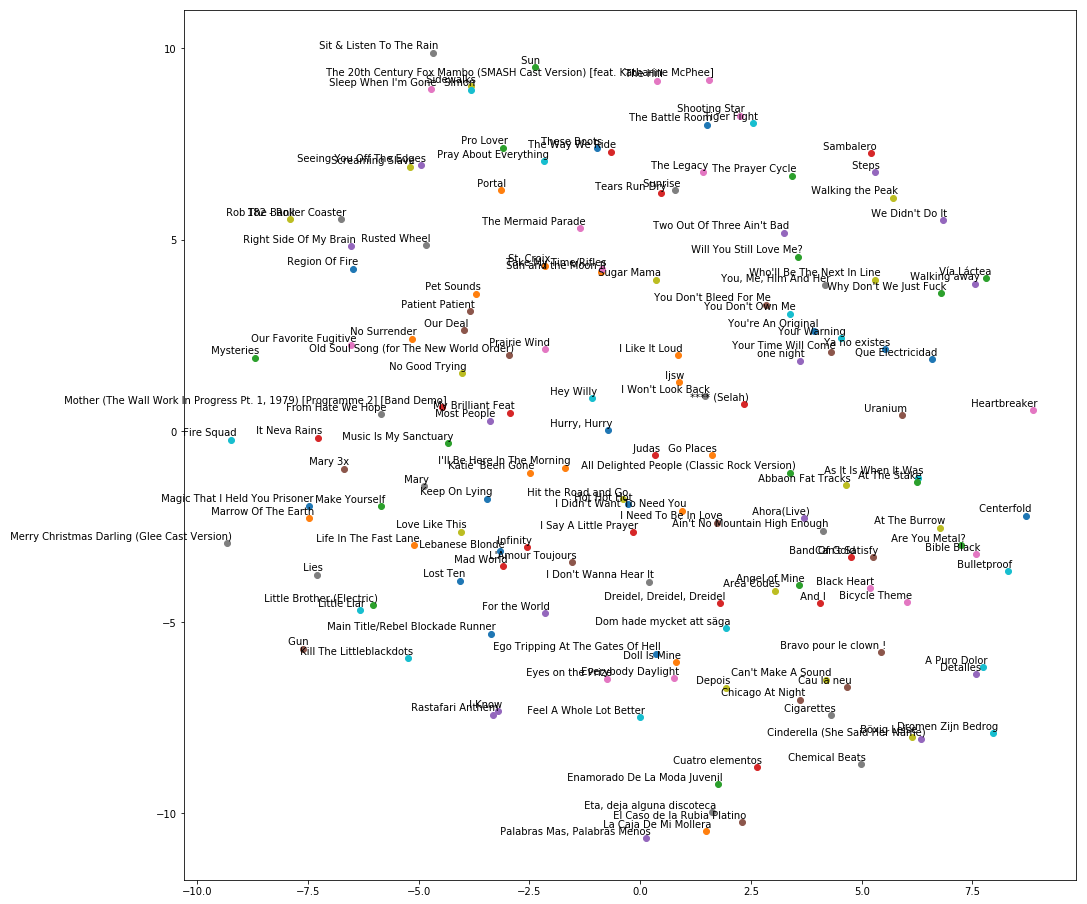

In [244]:
def label_format(label, condition=0):
    if condition == 1:
        return label.split("-", 1)[0]
    elif condition == 2:
        return label.split("-", 1)[1]
    else:
        return label


plt.figure(figsize=(16, 16)) 

for i in range(len(X_tsne)):
    plt.scatter(X_tsne[i,0],X_tsne[i,1])
    plt.annotate(label_format(labels[i], 2),
                 xy=(X_tsne[i,0],X_tsne[i,1]),
                 xytext=(5, 2),
                 textcoords='offset points',
                 ha='right',
                 va='bottom')
plt.show()

## Appendix

In [113]:
#sg ({0, 1}, optional) – Training algorithm: 1 for skip-gram
#min_count (int, optional) – Ignores all words with total frequency lower than this.
#window (int, optional) – Maximum distance between the current and predicted word within a sentence.
#sample (float, optional) – The threshold for configuring which higher-frequency words are randomly downsampled, useful range is (0, 1e-5).

#hs ({0, 1}, optional) – If 1, hierarchical softmax will be used for model training.
#If 0, and negative is non-zero, negative sampling will be used.

#negative (int, optional) – If > 0, negative sampling will be used, the int for negative specifies how many 
#“noise words” should be drawn (usually between 5-20). If set to 0, no negative sampling is used.

#model = gensim.models.Word2Vec(documents, min_count=1, workers=16, sg=1, size = 300, hs=1, window = 5)
#model.train(documents,total_examples=len(documents),epochs=1)

#window_size window-size
#it number of epochs 
#sample sub-sampling parameter
#power-alpha negative sampling distribution parameter

#window_size=3
#it=20 #increasing this leads to returning words with wrong similarity
#sample=0.0001 
#power_alpha=-0.5

#other
#size_embedding=50
#neg_sample=5
#workers=10
#min_count=5 #cold start?

#window_size=7
#it=20 #increasing this leads to returning words with wrong similarity
#sample=0.001 
#power_alpha=0.025

#size_embedding=50
#neg_sample=5
#workers=10
#min_count=2 #cold start?


#model = gensim.models.Word2Vec(test, size=size_embedding, window=window_size,
#                 min_count=min_count, workers=workers, sg=1, iter=it,
#                 sample=sample, negative=neg_sample, alpha=power_alpha)

#model.train(test,total_examples=len(test), epochs=model.iter)